In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

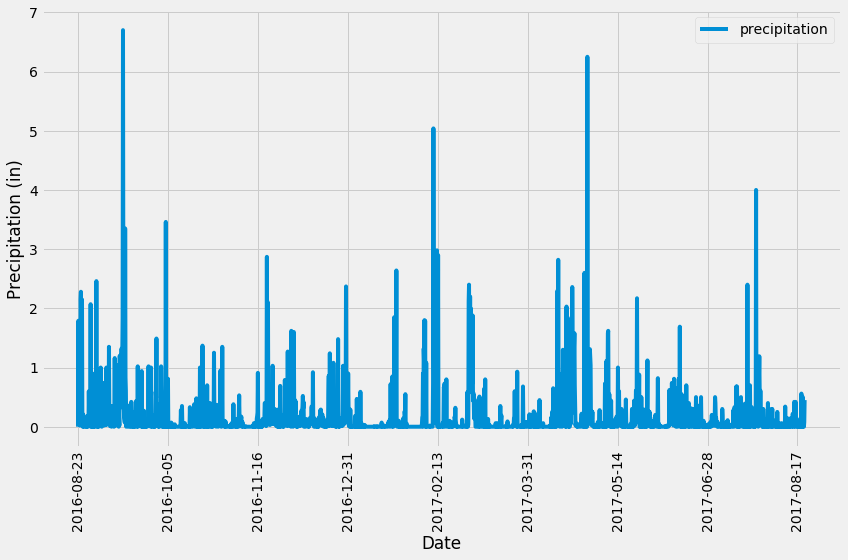

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= query_date)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_year.all(), columns=['date', 'precipitation'])
precipitation_df = precipitation_df.set_index('date')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')
precipitation_df = precipitation_df.dropna(how='any')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90, figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.legend(loc=1)
plt.tight_layout()
plt.savefig("Images/precipitation.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.station).count()
print(number_stations)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
print(lowest_temp)

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
print(highest_temp)

average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
print(average_temp)

54.0
85.0
71.66378066378067


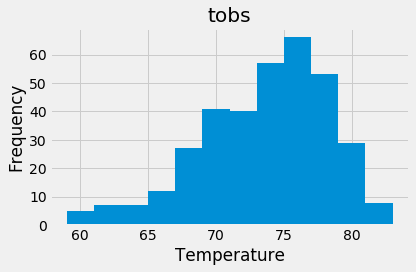

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year2 = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= query_date).filter(Measurement.station == 'USC00519281')

temp_df = pd.DataFrame(last_year2.all())
temp_df.hist('tobs', bins=12, figsize=(6,4))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("Images/TOBS_Histogram.png")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis I

In [16]:
june_avg_temp = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "06").scalar()
print(june_avg_temp)

dec_avg_temp = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == "12").scalar()
print(dec_avg_temp)

74.94411764705882
71.04152933421226


In [17]:
import scipy.stats as stats

In [18]:
june_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()

dec_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()

stats.ttest_ind(june_temps, dec_temps, equal_var=False)

Ttest_indResult(statistic=array([0.]), pvalue=array([1.]))

### Temperature Analysis II

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2017-02-01', '2017-02-15')

[(59.0, 69.72448979591837, 80.0)]

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
prior_min, prior_avg, prior_max = calc_temps('2017-02-01', '2017-02-15')[0]
prior_diff = [prior_max, prior_min]


### Daily Rainfall Average

In [61]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = dt.date(2017, 2, 1)
end_date = dt.date(2017, 2, 15)

session.query(Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    filter(Measurement.station == Station.station).group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00513117',
  7.3100000000000005,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519523',
  6.91,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519281',
  6.2299999999999995,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00514830',
  5.24,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  4.43,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519397', 3.45, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00517948', 0.0, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [63]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2018, 2, 1)
end_date = dt.date(2018, 2, 15)

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
